In [14]:
import pandas as pd
import torch
from rdkit import Chem
from torch_geometric.data import Data
import matplotlib.pyplot as plt
import networkx as nx

def molecule_to_graph(smiles):
    """Convert a SMILES string to a graph represented as a PyTorch Geometric Data object."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            raise ValueError(f"Invalid SMILES string: {smiles}")

        node_features = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
        edges = [(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()) for bond in mol.GetBonds()]
        
        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
        graph_data = Data(x=torch.tensor(node_features, dtype=torch.float).view(-1, 1), edge_index=edge_index)

        return graph_data

    except Exception as e:
        print(e)  # Log the error message
        return None  # Return None for invalid SMILES


def molecules_to_graphs(smiles_list):
    """Convert a list of SMILES strings to a list of graph representations."""
    graphs = []
    for smiles in smiles_list:
        graph = molecule_to_graph(smiles)
        if graph is not None:  # Only append valid graphs
            graphs.append(graph)
        else:
            print(f"Skipped invalid SMILES: {smiles}")  # Log invalid SMILES
    return graphs


def visualize_graph(graph):
    """Visualize a molecular graph using NetworkX and Matplotlib."""
    G = nx.Graph()
    for i in range(graph.x.size(0)):
        G.add_node(i, atomic_number=graph.x[i].item())
    for edge in graph.edge_index.t().tolist():
        G.add_edge(edge[0], edge[1])

    pos = nx.spring_layout(G)
    node_labels = {i: G.nodes[i]['atomic_number'] for i in G.nodes}
    nx.draw(G, pos, with_labels=True, labels=node_labels, node_size=700, node_color='lightblue')
    plt.title("Molecular Graph")
    plt.show()

'''
# Load the CSV file
csv_file = './data/PubChem_compound.csv'  # Change this to your file path
df = pd.read_csv(csv_file)

# Assuming the column containing SMILES strings is named 'isosmiles'
smiles_list = df['isosmiles'].dropna().tolist()  # Remove NaN values if any

# Convert SMILES to graphs
graphs = molecules_to_graphs(smiles_list)

# Prepare to save node features and edges
node_features_list = []
edges_list = []

# Output the graph data for each molecule and prepare to save
for i, graph in enumerate(graphs):
    print(f"Graph {i + 1}:")
    print("Node features:", graph.x)
    print("Edge index:", graph.edge_index)

    # Save node features and edges
    node_features_list.append(graph.x.numpy().flatten())  # Flatten for easier saving
    edges_list.append(graph.edge_index.numpy().T)  # Transpose for easier saving

    # Visualize each graph
    print(f"Visualizing Graph {i + 1}")
    visualize_graph(graph)

# Create DataFrames to save
node_features_df = pd.DataFrame(node_features_list)
edges_df = pd.DataFrame([edge.flatten() for edge in edges_list])

# Save to CSV
node_features_df.to_csv('node_features.csv', index=False, header=False)
edges_df.to_csv('edges.csv', index=False, header=False)

print("Node features and edges saved to CSV files.")
'''

'\n# Load the CSV file\ncsv_file = \'./data/PubChem_compound.csv\'  # Change this to your file path\ndf = pd.read_csv(csv_file)\n\n# Assuming the column containing SMILES strings is named \'isosmiles\'\nsmiles_list = df[\'isosmiles\'].dropna().tolist()  # Remove NaN values if any\n\n# Convert SMILES to graphs\ngraphs = molecules_to_graphs(smiles_list)\n\n# Prepare to save node features and edges\nnode_features_list = []\nedges_list = []\n\n# Output the graph data for each molecule and prepare to save\nfor i, graph in enumerate(graphs):\n    print(f"Graph {i + 1}:")\n    print("Node features:", graph.x)\n    print("Edge index:", graph.edge_index)\n\n    # Save node features and edges\n    node_features_list.append(graph.x.numpy().flatten())  # Flatten for easier saving\n    edges_list.append(graph.edge_index.numpy().T)  # Transpose for easier saving\n\n    # Visualize each graph\n    print(f"Visualizing Graph {i + 1}")\n    visualize_graph(graph)\n\n# Create DataFrames to save\nnode_fea

In [3]:
import pandas as pd
import torch
from torch_geometric.data import Data, Dataset, DataLoader

class MoleculeDataset(Dataset):
    def __init__(self, node_features_path, edges_path):
        super(MoleculeDataset, self).__init__()
        self.node_features_df = pd.read_csv(node_features_path, header=None)
        self.edges_df = pd.read_csv(edges_path, header=None)

    def len(self):
        return len(self.node_features_df)

    def get(self, idx):
        # Load node features
        node_features = torch.tensor(self.node_features_df.iloc[idx].values, dtype=torch.float).view(-1, 1)
        
        # Load edges
        edges = self.edges_df.iloc[idx].values.reshape(-1, 2).T
        edge_index = torch.tensor(edges, dtype=torch.long)

        # Create Data object
        graph_data = Data(x=node_features, edge_index=edge_index)
        return graph_data

# Load your dataset
node_features_path = 'node_features.csv'
edges_path = 'edges.csv'
dataset = MoleculeDataset(node_features_path, edges_path)


In [4]:
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


/home/mimasu/miniconda3/envs/lightning/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [5]:
import torch.nn as nn
import torch_geometric.nn as pyg_nn

class GNN(nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = pyg_nn.GCNConv(1, 16)
        self.conv2 = pyg_nn.GCNConv(16, 16)
        self.fc = nn.Linear(16, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = pyg_nn.global_mean_pool(x, data.batch)
        x = self.fc(x)
        return x


In [6]:
import pandas as pd

# Load existing dataset (assuming you have one with labels)
df = pd.read_csv('./data/PubChem_compound.csv')  # Change to your dataset

# Suppose 'isosmiles' is the column with SMILES and 'boiling_point' is the label
df_labels = df[['isosmiles', 'cmpdname']].dropna()

# Rename columns for clarity
df_labels.columns = ['isosmiles', 'label']

# Save to CSV
df_labels.to_csv('labels.csv', index=False)


In [23]:
import pandas as pd
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch_geometric.nn as pyg_nn
from torch_geometric.data import DataLoader

class GNN(nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = pyg_nn.GCNConv(in_channels=1, out_channels=16)
        self.conv2 = pyg_nn.GCNConv(in_channels=16, out_channels=32)
        self.pool = pyg_nn.global_mean_pool  # Pooling layer

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.pool(x, data.batch)  # Pool over the batch
        return x

class MoleculeModel(pl.LightningModule):
    def __init__(self, batch_size=32):
        super(MoleculeModel, self).__init__()
        self.model = GNN()
        self.loss_fn = nn.MSELoss()  # Change as needed

        self.batch_size = batch_size

    def forward(self, data):
        return self.model(data)

    def training_step(self, batch, batch_idx):
        data = batch

        # Forward pass
        output = self(data)
        
        # Create a dummy target. For example, if your model output has 32 dimensions, you can do:
        dummy_target = torch.zeros(output.size(), dtype=torch.float32).to(self.device)  # Adjust as necessary

        # Calculate loss
        loss = self.loss_fn(output.squeeze(), dummy_target)
        return loss

    def validation_step(self, batch, batch_idx):
        data = batch
        
        # Forward pass
        output = self(data)
        
        # Create a dummy target
        dummy_target = torch.zeros(output.size(), dtype=torch.float32).to(self.device)  # Adjust as necessary

        # Calculate loss
        loss = self.loss_fn(output.squeeze(), dummy_target)
        self.log('val_loss', loss)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.01)

# Function to prepare your DataLoader
def create_data_loader(smiles_list):
    graphs = []
    for smiles in smiles_list:
        graph = molecule_to_graph(smiles)  # Your function to convert SMILES to graph
        if graph is not None:
            graphs.append(graph)

    return DataLoader(graphs, batch_size=32, shuffle=True)  # Adjust batch size as needed

# Load the CSV file
csv_file = './data/PubChem_compound.csv'  # Change this to your file path
df = pd.read_csv(csv_file)

# Assuming the column containing SMILES strings is named 'isosmiles'
smiles_list = df['isosmiles'].dropna().tolist()  # Remove NaN values if any

# Prepare DataLoader
train_loader = create_data_loader(smiles_list)

# Initialize the model
model = MoleculeModel()

# Print the total number of graphs for debugging
print(f"Total graphs: {len(train_loader.dataset)}")

# Train the model
trainer = pl.Trainer(max_epochs=50)
trainer.fit(model, train_loader)



[22:43:51] WARNING: not removing hydrogen atom without neighbors
[22:43:51] WARNING: not removing hydrogen atom without neighbors
[22:43:52] Explicit valence for atom # 1 Cl, 7, is greater than permitted
[22:43:52] Explicit valence for atom # 1 Br, 3, is greater than permitted
[22:43:52] Explicit valence for atom # 1 Br, 5, is greater than permitted
[22:43:52] Explicit valence for atom # 1 Cl, 3, is greater than permitted


Invalid SMILES string: O=Cl(=O)(=O)F
Invalid SMILES string: FBr(F)F
Invalid SMILES string: FBr(F)(F)(F)F
Invalid SMILES string: FCl(F)F


[22:43:52] Explicit valence for atom # 1 Cl, 5, is greater than permitted
[22:43:52] WARNING: not removing hydrogen atom without neighbors
[22:43:52] WARNING: not removing hydrogen atom without neighbors
[22:43:52] WARNING: not removing hydrogen atom without neighbors


Invalid SMILES string: FCl(F)(F)(F)F


[22:43:52] WARNING: not removing hydrogen atom without neighbors
[22:43:52] WARNING: not removing hydrogen atom without neighbors
[22:43:53] WARNING: not removing hydrogen atom without neighbors
[22:43:53] WARNING: not removing hydrogen atom without neighbors
[22:43:53] WARNING: not removing hydrogen atom without neighbors
[22:43:53] WARNING: not removing hydrogen atom without neighbors
[22:43:53] WARNING: not removing hydrogen atom without neighbors
[22:43:53] WARNING: not removing hydrogen atom without neighbors
[22:43:53] WARNING: not removing hydrogen atom without neighbors
[22:43:53] WARNING: not removing hydrogen atom without neighbors
[22:43:53] WARNING: not removing hydrogen atom without neighbors
[22:43:53] WARNING: not removing hydrogen atom without neighbors
[22:43:53] WARNING: not removing hydrogen atom without neighbors
[22:43:53] WARNING: not removing hydrogen atom without neighbors
[22:43:53] WARNING: not removing hydrogen atom without neighbors
[22:43:53] WARNING: not r

Total graphs: 30421
Epoch 49: 100%|█████████████████████████████████████████| 951/951 [00:03<00:00, 242.75it/s, v_num=12]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|█████████████████████████████████████████| 951/951 [00:03<00:00, 242.59it/s, v_num=12]


In [11]:
print(self.labels_df.head())
print(self.labels_df.dtypes)

NameError: name 'self' is not defined

[22:52:16] WARNING: not removing hydrogen atom without neighbors
[22:52:16] WARNING: not removing hydrogen atom without neighbors
[22:52:16] Explicit valence for atom # 1 Cl, 7, is greater than permitted
[22:52:16] Explicit valence for atom # 1 Br, 3, is greater than permitted
[22:52:16] Explicit valence for atom # 1 Br, 5, is greater than permitted
[22:52:16] Explicit valence for atom # 1 Cl, 3, is greater than permitted


Invalid SMILES string: O=Cl(=O)(=O)F
Invalid SMILES string: FBr(F)F
Invalid SMILES string: FBr(F)(F)(F)F
Invalid SMILES string: FCl(F)F


[22:52:16] Explicit valence for atom # 1 Cl, 5, is greater than permitted
[22:52:16] WARNING: not removing hydrogen atom without neighbors
[22:52:16] WARNING: not removing hydrogen atom without neighbors
[22:52:16] WARNING: not removing hydrogen atom without neighbors


Invalid SMILES string: FCl(F)(F)(F)F


[22:52:17] WARNING: not removing hydrogen atom without neighbors
[22:52:17] WARNING: not removing hydrogen atom without neighbors
[22:52:17] WARNING: not removing hydrogen atom without neighbors
[22:52:17] WARNING: not removing hydrogen atom without neighbors
[22:52:17] WARNING: not removing hydrogen atom without neighbors
[22:52:17] WARNING: not removing hydrogen atom without neighbors
[22:52:17] WARNING: not removing hydrogen atom without neighbors
[22:52:17] WARNING: not removing hydrogen atom without neighbors
[22:52:17] WARNING: not removing hydrogen atom without neighbors
[22:52:17] WARNING: not removing hydrogen atom without neighbors
[22:52:17] WARNING: not removing hydrogen atom without neighbors
[22:52:17] WARNING: not removing hydrogen atom without neighbors
[22:52:17] WARNING: not removing hydrogen atom without neighbors
[22:52:17] WARNING: not removing hydrogen atom without neighbors
[22:52:17] WARNING: not removing hydrogen atom without neighbors
[22:52:17] WARNING: not r

Total graphs: 30421
Epoch 0:   2%|▉                                          | 22/951 [00:00<00:05, 172.02it/s, v_num=15]

/home/mimasu/miniconda3/envs/lightning/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Epoch 1:   4%|█▌                                         | 34/951 [00:00<00:05, 178.46it/s, v_num=15]

/home/mimasu/miniconda3/envs/lightning/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: Using a target size (torch.Size([21, 1, 1])) that is different to the input size (torch.Size([21, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Epoch 9: 100%|██████████████████████████████████████████| 951/951 [00:05<00:00, 181.92it/s, v_num=15]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████████████████████████████████████| 951/951 [00:05<00:00, 181.78it/s, v_num=15]


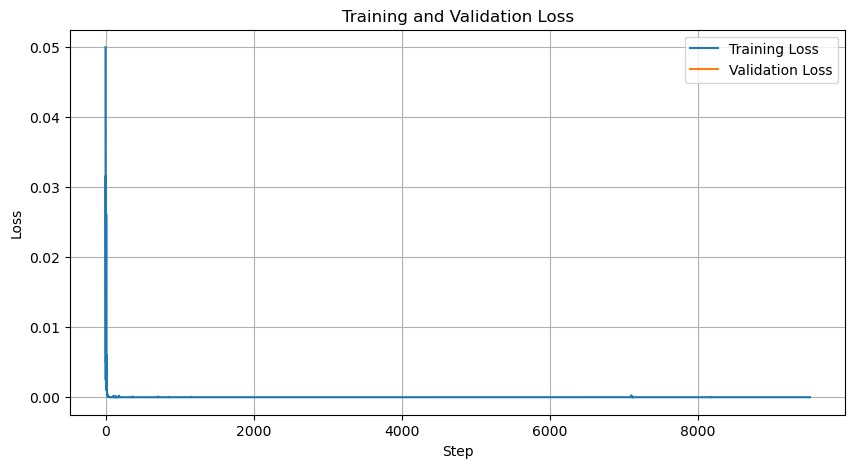

In [27]:
import pandas as pd
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch_geometric.nn as pyg_nn
from torch_geometric.data import DataLoader
from rdkit import Chem
import matplotlib.pyplot as plt

def molecule_to_graph(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            raise ValueError(f"Invalid SMILES string: {smiles}")

        node_features = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
        edges = [(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()) for bond in mol.GetBonds()]

        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
        graph_data = Data(x=torch.tensor(node_features, dtype=torch.float).view(-1, 1), edge_index=edge_index)

        return graph_data

    except Exception as e:
        print(e)
        return None

class EnhancedGNN(nn.Module):
    def __init__(self):
        super(EnhancedGNN, self).__init__()
        
        self.conv1 = pyg_nn.GCNConv(in_channels=1, out_channels=32)
        self.conv2 = pyg_nn.GCNConv(in_channels=32, out_channels=64)
        self.conv3 = pyg_nn.GCNConv(in_channels=64, out_channels=128)
        
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 32)
        self.dropout = nn.Dropout(p=0.5)
        self.output_layer = nn.Linear(32, 1)  # Output shape will be (batch_size, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.conv1(x, edge_index).relu()
        x = self.dropout(x)
        
        x = self.conv2(x, edge_index).relu()
        x = self.dropout(x)
        
        x = self.conv3(x, edge_index).relu()
        x = pyg_nn.global_mean_pool(x, data.batch)
        
        x = self.fc1(x).relu()
        x = self.dropout(x)
        
        x = self.fc2(x).relu()
        x = self.output_layer(x)  # Shape will be (batch_size, 1)
        
        return x

class MoleculeModel(pl.LightningModule):
    def __init__(self, batch_size=32):
        super(MoleculeModel, self).__init__()
        self.model = EnhancedGNN()
        self.loss_fn = nn.MSELoss()
        self.batch_size = batch_size
        self.train_losses = []
        self.val_losses = []

    def forward(self, data):
        return self.model(data)

    def training_step(self, batch, batch_idx):
        output = self(batch)
        dummy_target = torch.zeros(output.size(), dtype=torch.float32).to(self.device)  # Shape (batch_size, 1)
        loss = self.loss_fn(output, dummy_target.unsqueeze(1))  # Unsqueeze to shape (batch_size, 1)
        self.train_losses.append(loss.item())
        return loss

    def validation_step(self, batch, batch_idx):
        output = self(batch)
        dummy_target = torch.zeros(output.size(), dtype=torch.float32).to(self.device)  # Shape (batch_size, 1)
        loss = self.loss_fn(output, dummy_target.unsqueeze(1))  # Unsqueeze to shape (batch_size, 1)
        self.val_losses.append(loss.item())
        self.log('val_loss', loss)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.01)

    def on_train_end(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_losses, label='Training Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Step')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid()
        plt.show()

def create_data_loader(smiles_list):
    graphs = []
    for smiles in smiles_list:
        graph = molecule_to_graph(smiles)
        if graph is not None:
            graphs.append(graph)
    return DataLoader(graphs, batch_size=32, shuffle=True)

# Load the CSV file
csv_file = './data/PubChem_compound.csv'  # Change this to your file path
df = pd.read_csv(csv_file)
smiles_list = df['isosmiles'].dropna().tolist()

# Prepare DataLoader
train_loader = create_data_loader(smiles_list)

# Initialize the model
model = MoleculeModel()

# Print the total number of graphs for debugging
print(f"Total graphs: {len(train_loader.dataset)}")

# Train the model
trainer = pl.Trainer(max_epochs=10)
trainer.fit(model, train_loader)
